# EDA & Preprocessing

# Libraries

In [1]:
#General purpose
import pandas as pd
import numpy as np
import warnings
import collections, itertools

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#NLP
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import re

#Vectorizer
from gensim.corpora.dictionary import Dictionary

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = stopwords.words('spanish')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MegaTecnologia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MegaTecnologia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import data

In [3]:
df = pd.read_csv('PortezueloDelViento_tweets.csv')
df.head()

,id,created_at,user.name,text,favorite_count,retweet_count,truncated
0,1516491256934805508,Tue Apr 19 18:57:45 +0000 2022,javimenniti.eth,Estudios aseguran que Las #hidrolecticas se quedaran sin agua en un futuro proximo. Y nosotros seguimos debatiendo… https://t.co/6a1zKiBrqX,1,1,True
1,1516041596126568455,Mon Apr 18 13:10:57 +0000 2022,Revista +Industrias,#LaPampa: Conflicto por Portezuelo: Mendoza está pensando en un plan B https://t.co/u8QHqLKkSF\n#mendoza #energía… https://t.co/m58jjq0BfM,0,0,True
2,1514457323594465280,Thu Apr 14 04:15:37 +0000 2022,pato carrizo,"RT @MalosDias: #Ahora, en comunicación con Marcos López, del Grupo Olascoaga. En el comunicado del grupo 'Portezuelo no se hará' se oponen…",0,2,False
3,1514344913898557449,Wed Apr 13 20:48:57 +0000 2022,Silvia Rienzo,RT @petilombardi: #PortezueloDelViento tenia los avales en 2019 y por eso avanzamos con el proceso de licitación. En 2019 el presidente Mac…,0,14,False
4,1514323686462930945,Wed Apr 13 19:24:36 +0000 2022,Gustavo Lema,RT @petilombardi: #PortezueloDelViento tenia los avales en 2019 y por eso avanzamos con el proceso de licitación. En 2019 el presidente Mac…,0,14,False


In [4]:
df.shape

(10000, 7)

# ETL

In [5]:
#Everything to minus
def text_to_minus(text):
    return text.lower()

In [6]:
#Solo retenemos las letras y números
def remove_caracters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

In [7]:
# Add stopwords
add = ['PortezueloDelViento']
stop_words = stop_words + add

In [8]:
def remove_stopwords(text):
    word_tokens = text.split()
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_text = ' '.join(filtered_sentence)
    return filtered_text

In [9]:
def remove_tweet_expressions(text):
    text = text.replace('rt','')
    text = text.replace('https','')
    text = text.replace('twitter','')
    text = text.replace('retweet','')
    return text

In [10]:
#Creo el pipeline
def text_etl(text,
             minus = True,
             no_characters = True,
             no_stopwords = True,
             no_tweet_exp = True):
    
    if minus:
        text = text_to_minus(text)
    if no_characters:
        text = remove_caracters(text)
    if no_stopwords:
        text = remove_stopwords(text)
    if no_tweet_exp:
        text = remove_tweet_expressions(text)
    
    return text

In [11]:
df['process_text'] = df['text'].apply(lambda x: text_etl(x))

# EDA

In [12]:
tweets = df['process_text']

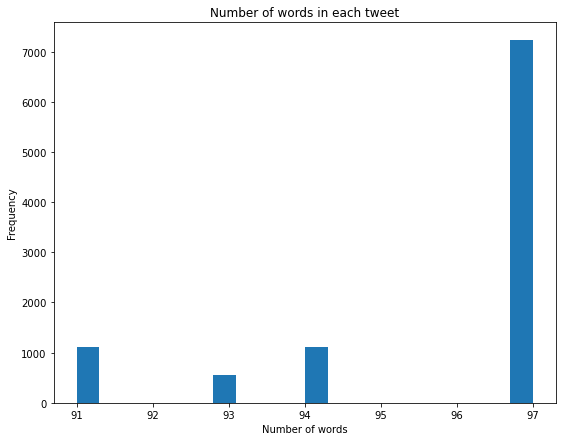

In [13]:
# Number of words in each tweet
_ = tweets.str.len().hist(grid=False, figsize=(9,7), bins=20)
_ = plt.xlabel('Number of words')
_ = plt.ylabel('Frequency')
_ = plt.title('Number of words in each tweet')
plt.show()

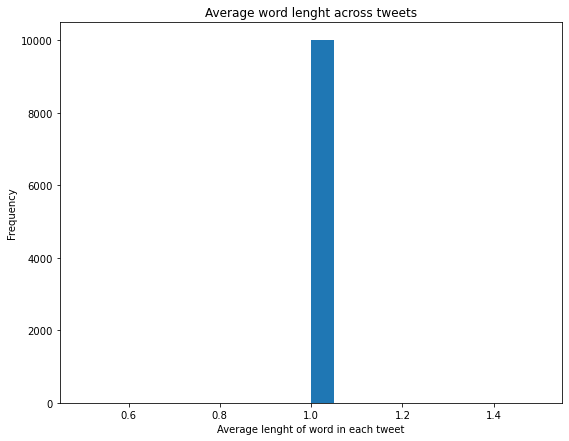

In [14]:
# let's check the average word lenght in each tweet
_ = tweets.apply(lambda x: [len(word) for word in x]).apply(lambda y: np.mean(y)).hist(grid=False, 
                                                                                       bins=20, 
                                                                                       figsize=(9,7))
_ = plt.xlabel('Average lenght of word in each tweet')
_ = plt.ylabel('Frequency')
_ = plt.title('Average word lenght across tweets')
plt.show()

## Vectorizer

In [15]:
#Create bag of words with gensim
tokens_tweets = df['process_text'].apply(word_tokenize)
dictionary = Dictionary(tokens_tweets)

adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(63 unique tokens: ['agua', 'aseguran', 'debatiendo', 'estudios', 'futuro']...) from 10000 documents (total 110001 corpus positions)
Dictionary lifecycle event {'msg': "built Dictionary(63 unique tokens: ['agua', 'aseguran', 'debatiendo', 'estudios', 'futuro']...) from 10000 documents (total 110001 corpus positions)", 'datetime': '2022-04-20T14:12:49.171278', 'gensim': '4.0.1', 'python': '3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'created'}


In [16]:
dictionary.filter_extremes(no_below=1, no_above=1, keep_n=5000)

discarding 0 tokens: []...
keeping 63 tokens which were in no less than 1 and no more than 10000 (=100.0%) documents
resulting dictionary: Dictionary(63 unique tokens: ['agua', 'aseguran', 'debatiendo', 'estudios', 'futuro']...)


In [17]:
print(dictionary)

Dictionary(63 unique tokens: ['agua', 'aseguran', 'debatiendo', 'estudios', 'futuro']...)


In [18]:
# Create corpus for bag of words (token IDs of each word with their frequencies
corpus = [dictionary.doc2bow(doc) for doc in tokens_tweets]

## More common words

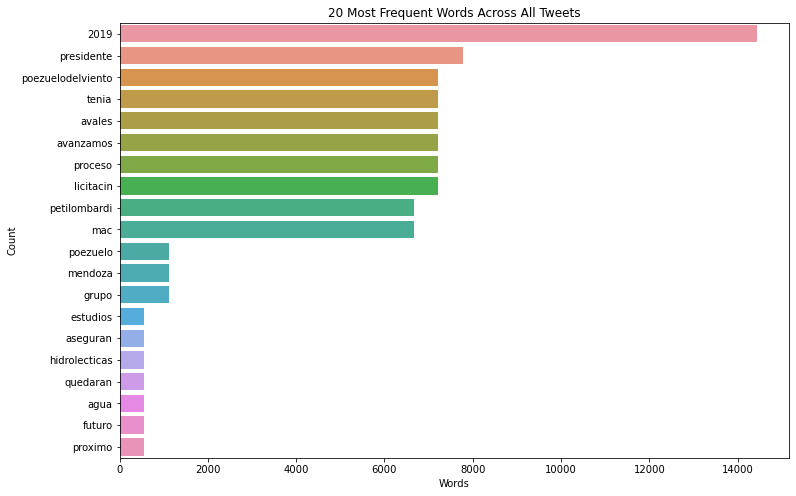

In [19]:
words = pd.DataFrame(Counter(" ".join(df["process_text"]).split()).most_common(20))
words.rename(columns={0:'word', 1: 'count'})

fig = plt.figure(figsize=(12,8))
fig = sns.barplot(y=words[0], x=words[1], orient='h')
fig = plt.ylabel("Count")
fig = plt.xlabel('Words')
fig = plt.title('20 Most Frequent Words Across All Tweets')
plt.show()

## Bi-grams

In [20]:
def explore_grams (tokens, n):
    grams = tokens.apply(lambda x: ngrams(x,n))
    _grams = grams.apply(lambda x: list(x))
    top_20_grams = Counter(itertools.chain.from_iterable(_grams)).most_common(20)
    
    top_gram = pd.DataFrame(top_20_grams, columns=['gram', 'frequency'])
    top_gram.set_index('gram', inplace=True)
    _ = plt.figure(figsize=(12,9))
    _ = sns.barplot(x=top_gram.frequency, y=top_gram.index, orient='h')
    _ = plt.xlabel('Frequency')
    _ = plt.ylabel('Grams')
    _ = plt.title('Top 20 Grams')
    plt.show()

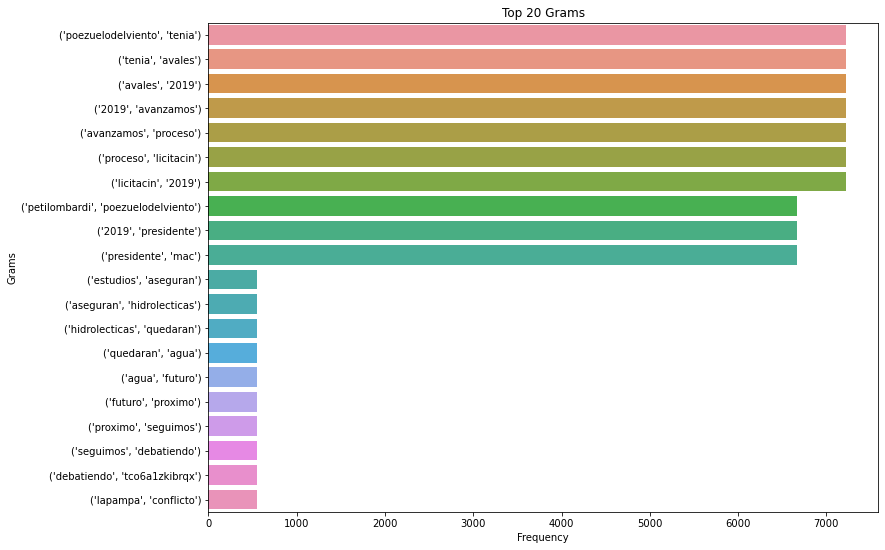

In [21]:
explore_grams(tokens_tweets, 2)

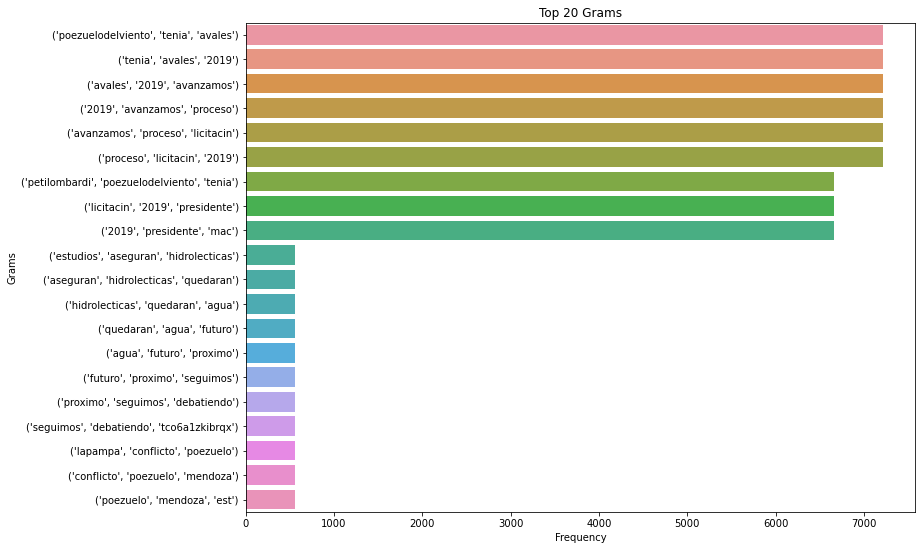

In [22]:
explore_grams(tokens_tweets, 3)

# Export

In [23]:
df.to_csv('procces_data.csv')